# CS 429: Information Retrieval

<br>

## Lecture 7: Term weighting and the Vector Space Model

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology 


---

<br><br><br><br>

Last time:

- How do we compress the contents of an index?

Today: 

- From boolean search to ranking


# Assignment 0 notes

- Why is this inefficient?  

In [1]:
def intersect(list1, list2):
    list(set(list1) & set(list2))

- `create_index`: no duplicate doc IDs
```
>>> create_index([['a', 'a']])
{'a': [0, 0]}
```

# Why is boolean search bad?

- Prone to user error
- Have to think of all possible ways of expressing information need
- Too many matching results

# Why is boolean search good?

- Users get exactly what they ask for
- Good for integrating with other software

# Problems with boolean search

- Too few results: "error: null ptr exception in line 2341" $\rightarrow$ 0 results
- Too many results: "error: null ptr exception" $\rightarrow$ 1M results
- User must carefully refine the query

<br><br><br><br>

# Ranked retrieval

- Order search results by **relevance** to query.
- Too many results is not a problem: user only looks at top 10-20.

<br><br><br><br>

# Ranked retrieval

**Problem:** Given a query $q$ and a set of documents $D$, compute a score $s_i \in [0, 1]$ for each document $d_i \in D$.

- higher scores $\rightarrow d_i$ is more relevant to $q$.

<br><br><br><br>


# Ranking one-word queries

- Search index for "dog".

- What should the score for a document be?

<br><br><br><br>

# Jaccard coefficient

$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

- $J(A, A) = 1$
- $J(A, B) = 0$ if $A \cap B = 0$

- Example: 
  - *q:* dogs with hats
  - $d_1:$ big cats wearing hats
  - $d_2:$ I like hats.
  - $J(q, d_1)$? 
  - $J(q, d_2)$?
  
  
<br><br><br><br>

$$J(q, d_1) = \frac{|\{hats\}|}{|\{dogs, with, hats, big, cats, wearing\}} = \frac{1}{6}$$


$$J(q, d_2) = \frac{|\{hats\}|}{|\{dogs, with, hats, I, like\}} = \frac{1}{5}$$

# Issues

- **term frequency**:  documents with more occurrences of query term should be ranked higher than documents with few occurrences.
  - q="dog", score("dog cat dog") > score("dog cat cat")
- **rare terms**: rare terms matter more than common terms
  - q="the dog", score("dog cat") > score("the cat")
- **length normalization**: how can we make the scores comparable for long and short documents?

# Term frequency

- Let $tf_{t,d}$ be the frequency of term $t$ in document $d$.
- What is the functional relationship between $tf_{t,d}$ and relevance?
  - linear, log, something else?
  
<br><br><br><br>

- $\log$ typically used
- The weight of term $t$ in $d$ is:
  - $w_{t,d} = 1 + \log tf_{t,d}$ if $tf_{t,d} > 0$; otherwise $0$.
  
  
- score $s_i = \sum_{t \in q \cap d_i}(1 + \log tf_{t,d_i})$
  - sum of term weights for unique terms in query and document
  
- If no query terms present? 0 score.


Populating the interactive namespace from numpy and matplotlib


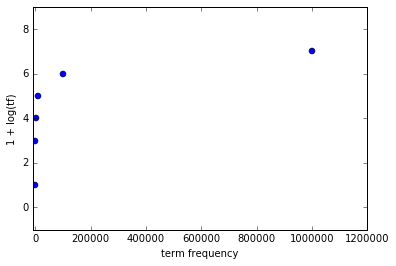

In [1]:
%pylab inline
tfs = [1, 100, 1000, 10000, 100000, 1000000]
xlim((-10000,1.2e6))
ylim((-1, 9))
plot(tfs, [1 + math.log10(tf) for tf in tfs], 'bo')
xlabel('term frequency')
ylabel('1 + log(tf)')

# Document frequency

- We want to weight rare terms more than common terms (e.g., *the* versus *excogitate*).

<br><br><br><br>

- **idf weight:**
  - Let $N$ be total number of documents
  - Let $df_t$ be the total number of documents that term $t$ appears in.
  - Define **inverse document freqency** as $idf_t = \log (\frac{N}{df_t})$

Populating the interactive namespace from numpy and matplotlib


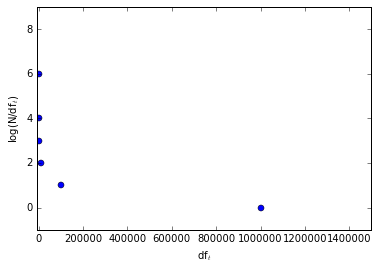

In [4]:
%pylab inline
N = 1e6
dfs = [1, 100, 1000, 10000, 100000, 1000000]
xlim((-10000,1.5e6))
ylim((-1, 9))
plot(dfs, [math.log10(1. * N/df) for df in dfs], 'bo')
xlabel('df$_t$')
ylabel('log(N/df$_t$)')

What effect does idf weight have on one term queries?
<br><br><br>
<br><br><br><br>  



- **none**

# tf-idf weight

- Multiply $tf$ and $idf$


- $w_{t,d} = (1 + \log tf_{t,d}) \times \log (\frac{N}{df_t})$

- Perhaps the most common baseline weighting system in IR
- Increases with term frequency in document; increases with rarity of term

**Final score:**

$$s_i = \sum_{t \in q \cap d_i} w_{t, d}$$

# Document representation

Previously, each document is a "bag-of-words"

- "I saw the man in the hat in the park." $\rightarrow$ `{i: 1, saw: 1, the: 3, man: 1, in: 2, hat: 1, park: 1}`
  - order doesn't matter; just term frequency
  
Now, each term is weighted by *tf-idf*.

# Document Space

Each document $d_i$ is now a vector in $V$-dimensional space, where $V$ is the number of terms.

- e.g., assume position0 is "dog" and position1 is "cat", then two documents could be:
  - $d_1 = \{10.6, 0.5\}$ (mostly about dogs)
  - $d_2 = \{0.2, 5.6\}$  (mostly about cats)

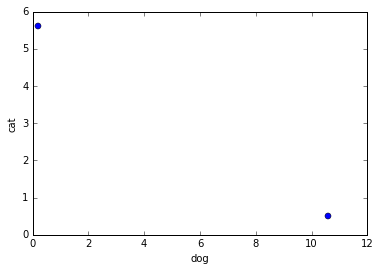

In [5]:
plot([10.6, 0.2], [.5, 5.6], 'bo')
xlabel('dog')
ylabel('cat')

<br><br><br><br>

# First idea: Euclidean distance

- Score a query by the distance between the query and document in vector space.

$ dist(a, b) = \sqrt{\sum_i (a_i - b_i)^2} $


# Problem with Euclidean distance

![length](files/length.png)

$q$ is similar to $d_2$, but because $d_2$ is longer, Euclidean distance is large

- Another way of thinking about it:
  - Let $d_i^2$ be $d_i$ appended to itself. 
  - $dist(d_i, d_i^2)$ should be small, but it is not

# Cosine similarity

**Idea:** score query by angle between query vector and document vector

![cosine](files/cosine.png)



# Cosine similarity

$$sim(a, b) = \frac{a \cdot b}{||a||\hbox{ } ||b||}$$

- $a \cdot b$ is dot product: $\sum_i a_i \times b_i$


- $||a||$ is norm: $\sqrt{\sum_i a_i^2}$

# Exercise

Given three documents:

- $d_1$: `['the', 'dog', 'barked']`
- $d_2$: `['the', 'dog', 'jumped']`
- $d_3$: `['a', 'cat', 'jumped']`


1. Compute tf-idf vectors for $d_1, d_2$
2. Compute the cosine similarity between $d_1$ and $d_2$

- $w_{t,d} = (1 + \log tf_{t,d}) \times \log (\frac{N}{df_t})$

$sim(a, b) = \frac{a \cdot b}{||a||\hbox{ } ||b||}$

- $a \cdot b$ is dot product: $\sum_i a_i \times b_i$

- $||a||$ is norm: $\sqrt{\sum_i a_i^2}$

<br><br><br><br><br>
<br><br><br><br><br>


First, create term frequency matrix:

| doc  | a | barked | cat | dog | jumped | the |
|------|---|--------|-----|-----|--------|-----|
|$d_1$ | 0 |  1     | 0   | 1   |   0    |  1  |
|$d_2$ | 0 |  0     | 0   | 1   |   1    |  1  |
|$d_3$ | 1 |  0     | 1   | 0   |   1    |  0  |


$N$ = 3

**tf-idf matrix:**

| doc  | a | barked | cat | dog | jumped | the |
|------|---|--------|-----|-----|--------|-----|
|$d_1$ | 0 |  log(3)     | 0   | log(3/2)   |   0    |  log(3/2)  |
|$d_2$ | 0 |  0     | 0   | log(3/2)  |   log(3)    |  log(3/2)  |
|$d_3$ | log(3) |  0     | log(3)   | 0   |   log(3/2)    |  0  |


** cosine**$(d_1, d_2)$:

$$  cos(d1, d2) = (d1 * d2) / (||d1||*||d2||)$$

$$d1 * d2 = (0 + 0 + 0 + log(3/2) * log(3/2) + 0 + log(3/2) * log(3/2))$$

$$||d1|| = sqrt(log(3)^2 + log(3/2)^2 + log(3/2)^2)$$

$$  ||d2|| = sqrt(log(3)^2 + log(3)^2 + log(3/2)^2)$$

